In [1]:
import ipywidgets as widgets
import traitlets
import pandas as pd
from IPython.display import display, clear_output
from ipyaggrid import Grid

from src.post_processing import PathWrangler, Path, Enzyme

In [2]:
pw = PathWrangler(
    path_filepath='../artifacts/processed_expansions/found_paths.json',
    pr_filepath='../artifacts/processed_expansions/predicted_reactions.json',
    kr_filepath='../artifacts/processed_expansions/known_reactions.json',
)

In [3]:
# UI widgets and layout

# input


starter_options, target_options = map(lambda x : sorted(set(x)), zip(*pw.starter_targets))
evidence_options = [(elt.value, elt.name) for elt in pw.enzyme_existence]
sort_options = [
    ("Mean RCMCS", 'mean_rcmcs'),
    ("Min RCMCS", 'min_rcmcs'),
    ("Max-min driving force", 'mdf')
]
kwargs_input_selector = dict(
    disabled=False,
    continuous_update=False,
    rows=len(starter_options),
    layout=widgets.Layout(
        width='auto',
        flex='1 1 auto',
    ),
    style=dict(
        description_width='100px',
    ),
)

input_selectors = widgets.HBox(
    children=[
        starter_selector := widgets.SelectMultiple(
            description='Starters:',
            options=starter_options,
            value=starter_options[:1],
            **kwargs_input_selector,
        ),
        target_selector := widgets.SelectMultiple(
            description='Targets:',
            options=target_options,
            value=target_options,
            **kwargs_input_selector,
        ),
        evidence_selector := widgets.SelectMultiple(
            description='Enzyme LOE:',
            options=evidence_options,
            value=[pw.enzyme_existence.PROTEIN.name],
            **kwargs_input_selector,
        ),
        sort_by_radio_buttons := widgets.Select(
            description='Sort paths by:',
            options=sort_options,
            value='mean_rcmcs',
            **kwargs_input_selector,
        ),
    ],
    layout=widgets.Layout(
        flex_flow='row wrap',
    ),
)

# output 

kwargs_output_selector = {
    **kwargs_input_selector,
    'layout': widgets.Layout(
        width='auto',
        flex='0 1 auto',
    ),
}

output_paths = widgets.VBox(
    children=[
        paths_label := widgets.Label(
            value='Awaiting path exploration',
        ),
        paths_selector := widgets.SelectMultiple(
            description='Paths:',
            **kwargs_output_selector,
        ),
        paths_viewer := widgets.Output(),
    ],
)

# UI overall

ui = widgets.VBox(
    children=[
        input_selectors,
        output_paths,
    ],
    layout=widgets.Layout(
        width='99%',
        justify_content='flex-start',
    ),
)

In [4]:
# custom widget builders

js_uniprot_id_renderer = '''
    function(params){
        if (params.value !== undefined && params.value !== null){
            return `<a href="https://www.uniprot.org/uniprotkb/${params.value}/entry" target="_blank" rel="noopener noreferrer">${params.value}</a>`;
        }
        return ""
    }
'''


def build_enzymes(enzymes: list[Enzyme]) -> Grid:
    df = (
        pd.DataFrame(data=[e.to_dict() for e in enzymes])
        .loc[:, ['uniprot_id', 'ec', 'organism', 'name', 'existence', 'reviewed', 'sequence']]
        .pipe(lambda df: df.set_index(pd.Index(range(1, len(df) + 1), name='idx')))
    )
    grid = Grid(
        grid_data=df,
        grid_options={
            'columnDefs': [
                {'headerName': '', 'field': df.index.name, 'width': 40},
                {'headerName': 'UniProt ID ⤴', 'field': 'uniprot_id', 'cellRenderer': js_uniprot_id_renderer, 'width': 120},
                {'headerName': 'EC', 'field': 'ec', 'width': 100},
                {'headerName': 'Organism', 'field': 'organism', 'width': 250},
                {'headerName': 'Name', 'field': 'name', 'width': 300},
                {'headerName': 'Existence', 'field': 'existence', 'width': 200},
                {'headerName': 'Reviewed', 'field': 'reviewed', 'width': 100},
                {'headerName': 'Sequence', 'field': 'sequence', 'width': 500},
            ],
            'enableSorting': True,
            'enableFilter': True,
            'enableColResize': True,
            'enableRangeSelection': True,
        },
        index=True,
        theme='ag-theme-balham',
        quick_filter=True,
        height=190,
        width=900,
    )
    grid.unsync = True
    return grid


def display_predicted_reaction(rxn_step, img):
    html = widgets.HTML(f'<b><u>Step #{rxn_step + 1}</u></b>')
    svg = widgets.Image.from_file(img)
    return widgets.VBox([html, svg])


def display_analogue(img, rcmcs):
    html = widgets.HTML(f'<b><u>{rcmcs * 100:.2f}% similar to predicted reaction</u></b>')
    svg = widgets.Image.from_file(img)
    return widgets.VBox([html, svg])


def widget_analogues_enzymes(krs, rcmcses):
    kr_elts = []
    enzyme_elts = []
    for kr, rcmcs in zip(krs, rcmcses):
        kr_elts.append(display_analogue(kr.image, rcmcs))
        enzyme_elts.append(build_enzymes(kr.enzymes))

    kr_selector = widgets.Dropdown(
        options=[(i + 1, i) for i in range(len(kr_elts))],
        value=0,
        description="Analogue: "
    )
    kr_stack = widgets.Stack(kr_elts, selected_index=0)
    kr_sel_disp = widgets.VBox([kr_selector, kr_stack])
    enzyme_stack = widgets.Stack(enzyme_elts, selected_index=0)
    _link_kr = widgets.jslink((kr_selector, 'index'), (kr_stack, 'selected_index'))
    _link_enz = widgets.jslink((kr_selector, 'index'), (enzyme_stack, 'selected_index'))

    return widgets.Tab(
        titles=['Known Analogues', 'Enzymes'],
        children=[kr_sel_disp, enzyme_stack],
    )


def widget_path_view(path: Path, k: int = 1):
    header = widgets.HTML(f"""
    <h3>{len(path.reactions)}-step path from {path.starter.upper()} to {path.target.upper()}<br>
    Max-min driving force = {path.mdf:.2f} kJ/mol<br>
    ID: {path.id}
    </h3>
    """)
    rows = [header]
    for i, rxn in enumerate(path.reactions):
        pr_elt = display_predicted_reaction(i, rxn.image)
        kr_elt = widget_analogues_enzymes(
            krs=rxn.top_analogues(k=k),
            rcmcses=rxn.top_rcmcs(k=k),
        )
        row = widgets.GridBox(
            children=[pr_elt,  kr_elt],
            layout=widgets.Layout(
                border='1px solid black',
                height='280px',
                grid_template_rows='auto',
                grid_template_columns='55% 45%',
            )
        )
        rows.append(row)
    return widgets.VBox(rows)

In [5]:
# event handlers and wiring

# on input change :: fetch paths & update path selector

def update_paths_selector(_change: traitlets.Bunch):
    path_objs = pw.get_paths(
        starters=starter_selector.value,
        targets=target_selector.value,
        filter_by_enzymes={'existence': evidence_selector.value},
        sort_by=sort_by_radio_buttons.value,
    )
    paths_selector.disabled = not path_objs
    options = [(idx + 1, path) for idx, path in enumerate(path_objs)]
    paths_selector.options = options
    if options:
        # avoid setting `value` when the options are empty
        # otherwise, traitlet validations go berserk
        paths_selector.value = [options[0][1]]


for input_selector in input_selectors.children:
    input_selector.observe(update_paths_selector, names=['value'])


# on paths selection change :: update paths label & render the paths viewer

def update_paths_label(change: traitlets.Bunch):
    paths_label.value = f'Fetched {len(change.owner.options)} paths'


def render_paths(change: traitlets.Bunch):
    with paths_viewer:
        clear_output()
        display(
            widgets.VBox([widget_path_view(path) for path in change.new])
        )


paths_selector.observe(update_paths_label, names=['value'])
paths_selector.observe(render_paths, names=['value'])

In [6]:
# display UI & kick off a selection
display(ui)
starter_selector.value = starter_options[:2]

In [23]:
from IPython.display import SVG
rules = pd.read_csv("/home/stef/bottle/data/rules/minimal1224_all_uniprot.tsv", sep='\t')
rules.set_index("Name", inplace=True)

def show_problem(pid: str, step: int, pw: PathWrangler = pw, rules: pd.DataFrame = rules):
    p = pw.get_path_with_id(pid)
    pr = p.reactions[step]
    a = pr.top_analogues(k=1)[0]
    pr_ops = set([o.split('_')[0] for o in pr.operators])
    a_ops = set([o.split('_')[0] for o in a.operators])
    inter_rules = pr_ops & a_ops
    for rule in inter_rules:
        print(f"{rule}: {rules.loc[rule, 'SMARTS']}")

    print("Predicted reaction")
    display(SVG(pr.image))

    print("Analogue")
    display(SVG(a.image))

rule0028: ([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])
Predicted reaction


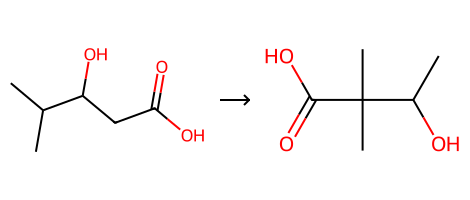

Analogue


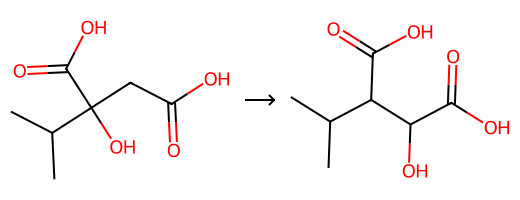



rule0126: [#6:1].[#6:2]-[#6:3]>>[#6:2].[#6:1]-[#6:3]
Predicted reaction


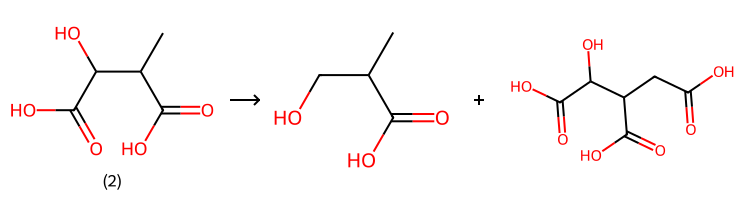

Analogue


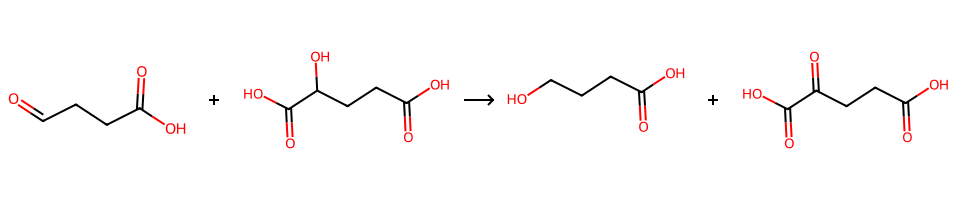



rule0126: [#6:1].[#6:2]-[#6:3]>>[#6:2].[#6:1]-[#6:3]
Predicted reaction


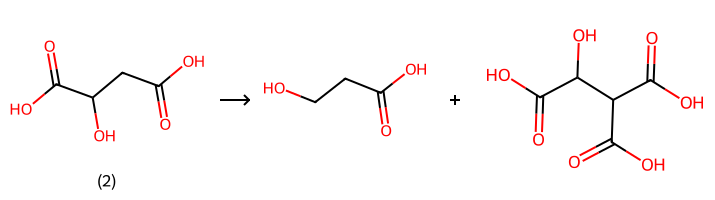

Analogue


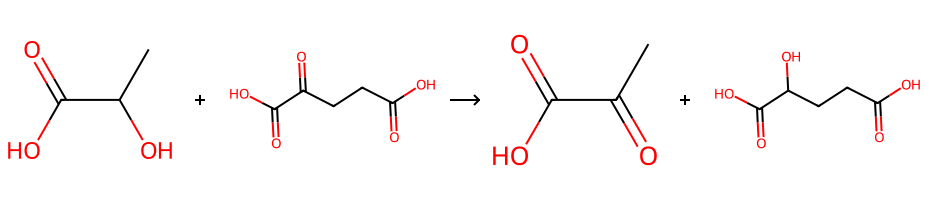



rule0126: [#6:1].[#6:2]-[#6:3]>>[#6:2].[#6:1]-[#6:3]
Predicted reaction


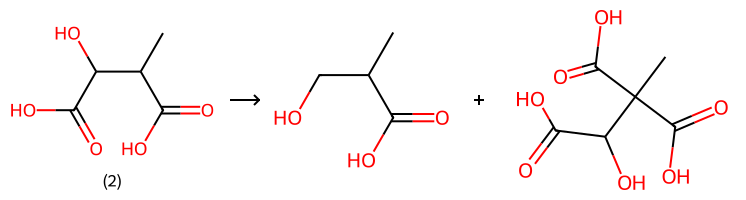

Analogue


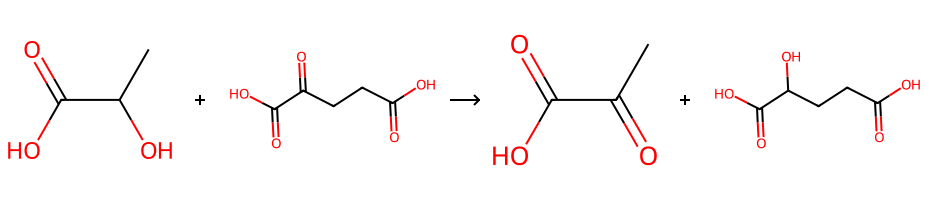



rule0028: ([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])
Predicted reaction


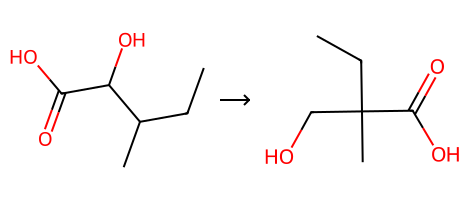

Analogue


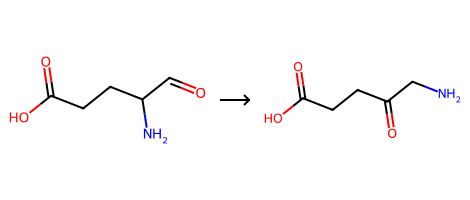



rule0028: ([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])
Predicted reaction


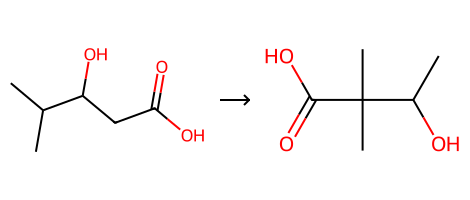

Analogue


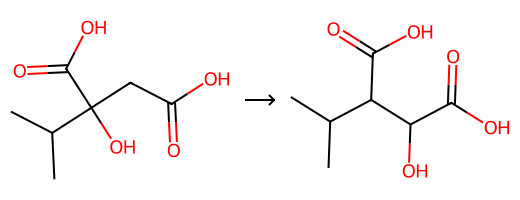

In [31]:
# Problematic
problems = [
    ('P019f0330406c83b4d12823f480e8f68c006ef345', -1),
    ('P4d4cf75ccd62b55a0686f46d6e4b52d860725fe5', 1),
    ('P5b5ed50f979c6bad62a65d71da88a84d4a259348', 0),
    ('P77b28de7590b39ebcf60a7a4f4bdde47767f2ae7', 1),
    ('Pef934dc8b4ba9f348f2d530a575a4467c056459f', 1), # Might be real, but not a good analogue
    ('P2eb5a964bdc1db846cd9496f22d0eda68941ab3d', -1)
]

for pid, step in problems:
    show_problem(pid, step)
    print('\n')


In [ ]:

# p = pw.get_path_with_id('P019f0330406c83b4d12823f480e8f68c006ef345')
# a = p.reactions[-1].top_analogues(k=1)[0]
# print(a.operators)
# print("rule0028: ", '([#6:1].[#6:2]-[#6:3])>>([#6:2].[#6:1]-[#6:3])')
# display(SVG(a.image))

# print('\n')
# p = pw.get_path_with_id('P4d4cf75ccd62b55a0686f46d6e4b52d860725fe5')
# pr = p.reactions[1]
# print(pr.operators)
# a = pr.top_analogues(k=1)[0]
# print(a.operators)
# print("rule0126: [#6:1].[#6:2]-[#6:3]>>[#6:2].[#6:1]-[#6:3]")
# print("rule0324: [#6:1]-[#8:2].[#6:3]=[#8:4]>>[#6:3]-[#8:4].[#6:1]=[#8:2]")
# display(SVG(a.image))